In [1]:
#Title 

In [2]:
#Deliverable 1 Population Statistics

In [1]:
!pip install wbdata

  Using cached wbdata-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
  Using cached dateparser-1.2.1-py3-none-any.whl.metadata (29 kB)
  Using cached shelved_cache-0.3.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached tabulate-0.8.10-py3-none-any.whl.metadata (25 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzlocal-5.2-py3-none-any.whl.metadata (7.8 kB)
Using cached wbdata-1.0.0-py3-none-any.whl (18 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
Using cached dateparser-1.2.1-py3-none-any.whl (295 kB)
Using cached shelved_cache-0.3.1-py3-none-any.whl (7.8 kB)
Using cached tabulate-0.8.10-py3-none-any.whl (29 kB)
Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
Using cached tzlocal-5.2-py3-none-any.whl (17 kB)
  Attempting uninstall: pytz
    Found exist

In [2]:
import wbdata
wbdata.get_topics()

Key '-3103126963367432501' not in persistent cache.
Key '227106575749895811' not in persistent cache.
Key '7436467346251549906' not in persistent cache.
Key '3655270159615251387' not in persistent cache.
Key '-7582113143592646134' not in persistent cache.
Key '-6160556471038580595' not in persistent cache.
Key '-8593126090946302812' not in persistent cache.
Key '-8429794609079505542' not in persistent cache.
Key '-7008237936525440003' not in persistent cache.
Key '-6111511030215575182' not in persistent cache.
Key '6481420836995954194' not in persistent cache.
Key '-2991289749352236928' not in persistent cache.
Key '291709745627092853' not in persistent cache.
Key '8190794054027284337' not in persistent cache.
Key '-1264037846890364857' not in persistent cache.
Key '-6736880505134383010' not in persistent cache.
Key '-4790997620977337413' not in persistent cache.
Key '1744144466023392330' not in persistent cache.
Key '8953505236525046425' not in persistent cache.
Key '-6163005298067176

  id  value
----  -------------------------------
   1  Agriculture & Rural Development
   2  Aid Effectiveness
   3  Economy & Growth
   4  Education
   5  Energy & Mining
   6  Environment
   7  Financial Sector
   8  Health
   9  Infrastructure
  10  Social Protection & Labor
  11  Poverty
  12  Private Sector
  13  Public Sector
  14  Science & Technology
  15  Social Development
  16  Urban Development
  17  Gender
  18  Millenium development goals
  19  Climate Change
  20  External Debt
  21  Trade

In [3]:
import pandas as pd
import numpy as np

In [4]:
wbdata.get_sources()

  id  name
----  --------------------------------------------------------------------
   1  Doing Business
   2  World Development Indicators
   3  Worldwide Governance Indicators
   5  Subnational Malnutrition Database
   6  International Debt Statistics
  11  Africa Development Indicators
  12  Education Statistics
  13  Enterprise Surveys
  14  Gender Statistics
  15  Global Economic Monitor
  16  Health Nutrition and Population Statistics
  18  IDA Results Measurement System
  19  Millennium Development Goals
  20  Quarterly Public Sector Debt
  22  Quarterly External Debt Statistics SDDS
  23  Quarterly External Debt Statistics GDDS
  25  Jobs
  27  Global Economic Prospects
  28  Global Financial Inclusion
  29  The Atlas of Social Protection: Indicators of Resilience and Equity
  30  Exporter Dynamics Database – Indicators at Country-Year Level
  31  Country Policy and Institutional Assessment
  32  Global Financial Development
  33  G20 Financial Inclusion Indicators
  34  Glob

In [7]:
indicators = wbdata.get_indicators(source=40)
indicators

id                 name
-----------------  -------------------------------------------------------------------
SH.DTH.0509        Number of deaths ages 5-9 years
SH.DTH.0514        Number of deaths ages 5-14 years
SH.DTH.1014        Number of deaths ages 10-14 years
SH.DTH.1019        Number of deaths ages 10-19 years
SH.DTH.1519        Number of deaths ages 15-19 years
SH.DTH.2024        Number of deaths ages 20-24 years
SH.DTH.IMRT        Number of infant deaths
SH.DTH.IMRT.FE     Number of infant deaths, female
SH.DTH.IMRT.MA     Number of infant deaths, male
SH.DTH.MORT        Number of under-five deaths
SH.DTH.MORT.FE     Number of under-five deaths, female
SH.DTH.MORT.MA     Number of under-five deaths, male
SH.DTH.NMRT        Number of neonatal deaths
SH.DYN.0509        Probability of dying among children ages 5-9 years (per 1,000)
SH.DYN.0514        Probability of dying at age 5-14 years (per 1,000 children age 5)
SH.DYN.1014        Probability of dying among adolescents ages 1

In [24]:
sexdict = {'Male':'MA', 'Female':'FE'}
def population(year,sex,age_range,place):
        lower, upper = age_range[0], age_range[1]
        df = population_data_frames(sex, age_range, place).reset_index()
        df = df[df['date'] == f'{year}-01-01'] # selecting relevant year
        df.drop(['date', 'country'], axis=1, inplace=True)
        extra = ((upper - (int(df.columns[-1][-4:-2]))) / 5) * (df.iloc[:,-1].to_list()[0]) # controls for age ranges not on bounds, could change to 
                                                                          # year by year subtraction
        final = df.sum(axis=1) - extra
        return f' There were {final.iloc[0]} {sex.lower()}s living in {place} in {year}'

In [25]:
population(1990, 'Male', (10,33), 'CHN')

' There were 246693887.8 males living in CHN in 1990'

In [65]:
def population_data_frames(sex, age_range, place,):
    lower, upper = age_range[0], age_range[1]
    assert upper >= lower, "Invalid date range!" #Part of Deliverable 2
    assert sex in ["Male", "Female", "Both"], "Invalid sex Please use one of the following: Male, Female, Both"
    if sex == "Both":
        return population_data_frames("Male",age_range,place).merge(population_data_frames("Female",age_range,place), on=["date", "country"])
    if upper > 80:
        upper = 'UP'
    if upper == lower + 4:
        label = f'SP.POP.{lower:02d}{upper}.{sexdict[sex]}.IN'
        df = wbdata.get_dataframe(label,country=place,parse_dates=True)
    else:
        yrs = [(x, x+4) for x in range(lower, upper, 5)]
        ranges = [f'{x[0]:02d}{x[1]:02d}' for x in yrs]
        var = [f"SP.POP.{x}.{sexdict[sex]}" for x in ranges]
        feed = {x: f"{sex} {ranges[var.index(x)]}" for x in var} # constructs variable dictionary to be fed to wbdata
        
        df = wbdata.get_dataframe(feed,country=place,parse_dates=True).reset_index()
        df['country'] = place
        df.set_index(['country', 'date'], inplace=True)
    return df

In [66]:
df = population_data_frames("Both", (0,80), 'CHN')
df

,,Male 0004,Male 0509,Male 1014,Male 1519,Male 2024,Male 2529,Male 3034,Male 3539,Male 4044,Male 4549,...,Female 3034,Female 3539,Female 4044,Female 4549,Female 5054,Female 5559,Female 6064,Female 6569,Female 7074,Female 7579
date,country,,,,,,,,,,,,,,,,,,,,,
2023-01-01,CHN,30390275.0,46921541.0,47697475.0,43619845.0,42690196.0,45996968.0,58571312.0,58164459.0,50128672.0,49849324.0,...,52861422.0,54111081.0,47658004.0,48165337.0,60432093.0,56825905.0,37771419.0,39685195.0,31522585.0,18369107.0
2022-01-01,CHN,34407301.0,47977432.0,46945694.0,42880142.0,43079433.0,47322938.0,61347262.0,56040230.0,48623953.0,52814513.0,...,55702933.0,52391805.0,46321543.0,51130200.0,60536192.0,56551300.0,35002089.0,39507542.0,29106909.0,17241445.0
2021-01-01,CHN,38802141.0,48127269.0,46077575.0,42441714.0,43637348.0,48943931.0,63431979.0,54207913.0,47300851.0,55783379.0,...,57929324.0,50904100.0,45150868.0,54098374.0,59738602.0,53597653.0,35660756.0,38793955.0,26676375.0,16375324.0
2020-01-01,CHN,42401148.0,48099312.0,45390757.0,42444894.0,44208685.0,51917714.0,63016755.0,52572479.0,47188710.0,58708249.0,...,57874577.0,49544962.0,45127659.0,57028683.0,58862173.0,48420766.0,37969600.0,37695737.0,24481027.0,15706266.0
2019-01-01,CHN,45006875.0,48004396.0,44534610.0,42626158.0,45014490.0,55706672.0,60783908.0,51377332.0,48144457.0,61076492.0,...,56135406.0,48557018.0,46127571.0,59426420.0,57903342.0,43397958.0,40213974.0,35946934.0,22477861.0,15164232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964-01-01,CHN,53250448.0,48925593.0,45210547.0,32772310.0,27179605.0,26566937.0,24330081.0,21031169.0,18185693.0,15660355.0,...,22007969.0,19483299.0,17392150.0,15431263.0,13393101.0,11786993.0,9466826.0,6632284.0,4460153.0,2517810.0
1963-01-01,CHN,47951039.0,50749733.0,43265071.0,31245247.0,27269359.0,26878889.0,23871048.0,20785092.0,17811841.0,15758791.0,...,21660173.0,19354179.0,17095469.0,15479965.0,13256152.0,11717468.0,9144942.0,6641740.0,4377684.0,2488273.0
1962-01-01,CHN,44777918.0,50854256.0,40877563.0,29902774.0,27482213.0,26824171.0,23384228.0,20378091.0,17531795.0,15710166.0,...,21287773.0,19076777.0,16884402.0,15370624.0,13165906.0,11656254.0,8846123.0,6626940.0,4305783.0,2473695.0


Deliverable 4: Population Pyramids Function

In [67]:
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np

def population_pyramid(df,year):
    """Plots population pyramid given dataframe from population dataframe function and year."""
    df = df.reset_index()
    df = df.drop('country',axis=1)
    df = df.set_index('date')
    year = f"{year}-01-01"
    age_ranges = [f"{i:02d}{i+4:02d}" for i in range(0, 80, 5)]
    age_ranges.append("80UP")
    layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Population'))
    bins = [go.Bar(x = df.loc[year,:].filter(regex="Male").values,
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='blue'),
               hoverinfo='skip'
               ),

        go.Bar(x = -df.loc[year,:].filter(regex="Female").values,
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip',
               )
        ]
    py.iplot(dict(data=bins, layout=layout))

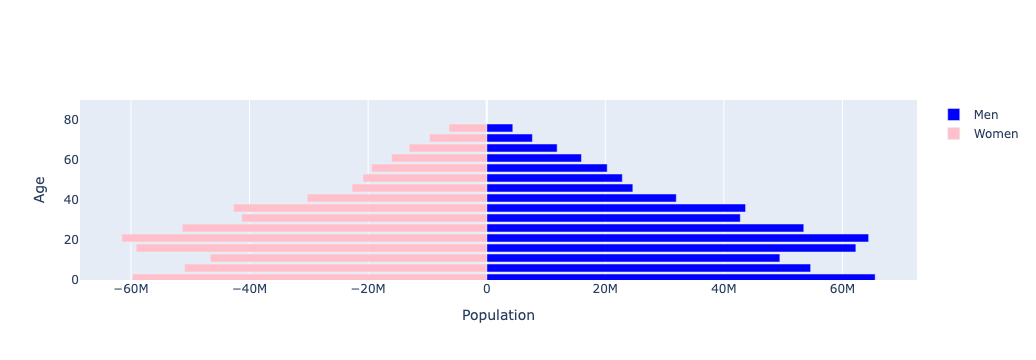

In [68]:
population_pyramid(df, 1990)

Deliverable 5: Animated Population Pyramids Function

In [63]:
import plotly.graph_objects as go

def population_pyramid_slider(df):
    """Plots animated population pyramid given dataframe from population dataframe function"""
    years = list(range(1960, 2024))
    df = df.reset_index()
    df = df.drop('country',axis=1)
    df = df.set_index('date')
    age_ranges = [f"{i:02d}{i+4:02d}" for i in range(0, 80, 5)]
    age_ranges.append("80UP")
    
    y_values = [int(s[:2]) for s in age_ranges]

    initial_year = years[0]
    initial_year_str = f"{initial_year}-01-01"

    male_population = df.loc[initial_year_str, :].filter(regex="Male").values
    female_population = df.loc[initial_year_str, :].filter(regex="Female").values

    bars = [
        go.Bar(
            x=male_population,
            y=y_values,
            orientation='h',
            name='Men',
            marker=dict(color='blue'),
            hoverinfo='x+y'
        ),
        go.Bar(
            x=-female_population,
            y=y_values,
            orientation='h',
            name='Women',
            marker=dict(color='pink'),
            hoverinfo='x+y'
        )
    ]

    frames = []
    for year in years:
        year_str = f"{year}-01-01"
        if year_str in df.index:  
            frame_male = df.loc[year_str, :].filter(regex="Male").values
            frame_female = df.loc[year_str, :].filter(regex="Female").values
        else:
            frame_male = [0] * len(y_values)
            frame_female = [0] * len(y_values)

        frames.append(
            go.Frame(
                data=[
                    go.Bar(x=frame_male, y=y_values),
                    go.Bar(x=-frame_female, y=y_values)
                ],
                name=str(year)
            )
        )

    layout = go.Layout(
        title="Population Pyramid Over Time",
        barmode='overlay',
        yaxis=dict(title='Age', range=[0, max(y_values) + 5]),
        xaxis=dict(title='Population', tickformat=",", showgrid=True),
        bargap=0.1,
        template="plotly_white",
        height=600,
        margin=dict(t=150, b=50),
        updatemenus=[{
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 30},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 1.25,
            "yanchor": "top"
        }],
        sliders=[{
            "active": 0,
            "yanchor": "bottom",
            "xanchor": "left",
            "currentvalue": {"prefix": "Year: ", "font": {"size": 20}},
            "pad": {"b": 0, "t": 100},
            "len": 0.9,
            "x": 0.1,
            "y": 1.15,
            "steps": [
                {"args": [[str(year)], {"frame": {"duration": 300, "redraw": True}, "mode": "immediate"}], "label": str(year), "method": "animate"}
                for year in years
            ]
        }]
    )

    fig = go.Figure(data=bars, layout=layout, frames=frames)
    fig.show()

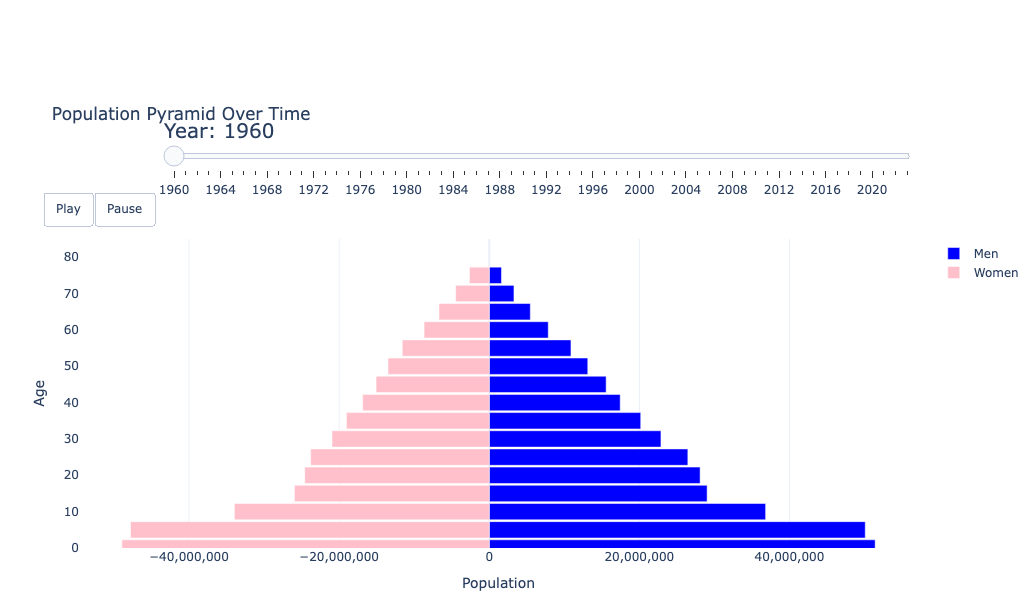

In [64]:
population_pyramid_slider(df)